# **Optimasi Rute dan Estimasi Waktu Pengiriman Logistik Menggunakan Representasi Graf Berbobot Dinamis (*Dynamic Weighted Graph*) Berbasis Logika Predikat pada Kondisi Lalu Lintas dan Cuaca.**
---
**Anggota Kelompok:**
1. Trisha Garnis Wahningyun (L0224012)
2. Nadhifa Sakha Tri Yasmin (L0224036)
3. Kayla Maharani Muzaki (L0224050)

### **Abstrak**
Proyek ini bertujuan untuk mensimulasikan sistem navigasi logistik cerdas yang mengimplementasikan materi **Matematika Diskrit**. Berbeda dengan navigasi biasa yang statis, sistem ini menggunakan **Teori Graf** untuk perhitungan jarak fisik dan **Logika Predikat** untuk memprediksi keterlambatan akibat variabel dinamis (cuaca & lalu lintas).

### _**Import Library**_

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from math import radians, cos, sin, asin, sqrt
import warnings
warnings.filterwarnings('ignore')

# Konfigurasi tampilan grafik
sns.set_style("whitegrid")
print("Library berhasil dimuat!")

Library berhasil dimuat!


## **1. Preprocessing Data**
Langkah pertama adalah memuat dataset **Amazon Delivery** dan melakukan pembersihan data (*Data Cleaning*). Data yang mengandung nilai kosong (*null*) harus dihapus agar tidak mengganggu perhitungan logika matematika selanjutnya.

### _**Load & Clean Data**_

In [4]:
try:
    df = pd.read_csv('../data/amazon_delivery.csv')
    print("✅ Dataset berhasil dibaca.")
except FileNotFoundError:
    print("File tidak ditemukan! Cek path folder data.")

# Menghapus data kosong
df_clean = df.dropna().copy()

# Menampilkan Info Data
print(f"Jumlah data awal: {len(df)}")
print(f"Jumlah data bersih: {len(df_clean)}")
display(df_clean.head(10))

✅ Dataset berhasil dibaca.
Jumlah data awal: 43739
Jumlah data bersih: 43594


,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys
5,fxuu788413734,22,4.8,17.431668,78.408321,17.461668,78.438321,2022-03-11,21:20:00,21:30:00,Cloudy,Jam,motorcycle,Urban,130,Toys
6,njmo150975311,33,4.7,23.369746,85.339820,23.479746,85.449820,2022-03-04,19:15:00,19:30:00,Fog,Jam,scooter,Metropolitian,200,Toys
7,jvjc772545076,35,4.6,12.352058,76.606650,12.482058,76.736650,2022-03-14,17:25:00,17:30:00,Cloudy,Medium,motorcycle,Metropolitian,160,Snacks
8,uaeb808891380,22,4.8,17.433809,78.386744,17.563809,78.516744,2022-03-20,20:55:00,21:05:00,Stormy,Jam,motorcycle,Metropolitian,170,Electronics
9,bgvc052754213,36,4.2,30.327968,78.046106,30.397968,78.116106,2022-02-12,21:55:00,22:10:00,Fog,Jam,motorcycle,Metropolitian,230,Toys


#### **Deskripsi Dataset**

Dataset yang digunakan adalah data logistik pengiriman barang (*Amazon Delivery Dataset*). Data ini memuat informasi geografis, kondisi agen, serta variabel lingkungan yang mempengaruhi waktu pengiriman.

Berikut adalah definisi dari setiap atribut (kolom) dalam dataset:

| Nama Kolom | Deskripsi & Kegunaan dalam MatDis |
| :--- | :--- |
| **Order_ID** | ID unik untuk setiap pesanan pengiriman. |
| **Agent_Age** | Umur kurir pengirim. |
| **Agent_Rating** | Nilai rating performa kurir (Skala 1-5). Digunakan untuk **Seleksi Himpunan**. |
| **Store_Latitude/Longitude** | Koordinat GPS lokasi toko (Titik Awal / Simpul Graf). |
| **Drop_Latitude/Longitude** | Koordinat GPS lokasi tujuan (Titik Akhir / Simpul Graf). |
| **Order_Date** | Tanggal pesanan dibuat. |
| **Order_Time** | Jam pesanan masuk. |
| **Pickup_Time** | Jam barang diambil oleh kurir. |
| **Weather** | Kondisi cuaca (*Sunny, Stormy, Fog*, dll). Premis utama dalam **Logika Predikat**. |
| **Traffic** | Kepadatan lalu lintas (*Jam, High, Medium, Low*). Premis kedua dalam **Logika Predikat**. |
| **Vehicle** | Jenis kendaraan (*Motorcycle, Scooter*). Digunakan untuk **Filter Himpunan**. |
| **Area** | Tipe area pengiriman (*Urban, Metropolitan*). |
| **Delivery_Time** | Waktu tempuh aktual dalam menit (Target yang diprediksi). |
| **Category** | Jenis barang yang dikirim (*Clothing, Electronics*, dll). |

---
**Mapping ke Materi Kuliah:**
1.  **Teori Graf:** Kolom `Latitude` & `Longitude` digunakan sebagai simpul ($V$) untuk menghitung bobot jarak ($w$).
2.  **Logika Matematika:** Kolom `Weather` & `Traffic` digunakan sebagai proposisi ($p, q$) untuk menentukan penalti waktu.
3.  **Teori Himpunan:** Kolom `Vehicle` & `Agent_Rating` digunakan untuk memfilter himpunan kurir terbaik.

### **Cek Nilai Unik**

In [15]:
print(">> DAFTAR SEMUA KOLOM")
other_cols = [col for col in df_clean.columns if col != 'Vehicle']
print(other_cols)

# Cek Nilai Unik pada kolom teks
print("\n>> PENGECEKAN NILAI UNIK")
cols_to_check = df_clean.select_dtypes(include=['object']).columns

for col in cols_to_check:
    # Skip kolom yang tidak perlu dicek uniknya (ID, Tanggal, Waktu)
    if any(x in col for x in ['ID', 'Date', 'Time']):
        continue
        
    print(f"\n>> Kolom: {col}")
    unique_values = df_clean[col].unique()
    print(unique_values)

>> DAFTAR SEMUA KOLOM
['Order_ID', 'Agent_Age', 'Agent_Rating', 'Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Order_Date', 'Order_Time', 'Pickup_Time', 'Weather', 'Traffic', 'Area', 'Delivery_Time', 'Category', 'jarak_km', 'estimasi_waktu']

>> PENGECEKAN NILAI UNIK

>> Kolom: Weather
['Sunny' 'Stormy' 'Sandstorms' 'Cloudy' 'Fog' 'Windy']

>> Kolom: Traffic
['High ' 'Jam ' 'Low ' 'Medium ']

>> Kolom: Vehicle
['motorcycle ' 'scooter ' 'van']

>> Kolom: Area
['Urban ' 'Metropolitian ' 'Semi-Urban ' 'Other']

>> Kolom: Category
['Clothing' 'Electronics' 'Sports' 'Cosmetics' 'Toys' 'Snacks' 'Shoes'
 'Apparel' 'Jewelry' 'Outdoors' 'Grocery' 'Books' 'Kitchen' 'Home'
 'Pet Supplies' 'Skincare']


## **2. Implementasi Teori Graf (Perhitungan Jarak Fisik)**

Dalam representasi graf $G = (V, E)$:
* **Simpul ($V$):** Titik koordinat Toko (*Store*) dan Titik Tujuan (*Drop*).
* **Sisi ($E$):** Jalur lurus yang menghubungkan kedua simpul.
* **Bobot ($W$):** Jarak fisik antar titik dalam Kilometer.

Karena bumi berbentuk bola (bukan datar), jarak Euclidean tidak akurat. Kita menggunakan **Rumus Haversine** untuk menghitung jarak geodesik:

$$a = \sin^2\left(\frac{\Delta\phi}{2}\right) + \cos(\phi_1)\cos(\phi_2)\sin^2\left(\frac{\Delta\lambda}{2}\right)$$
$$c = 2 \cdot \text{atan2}(\sqrt{a}, \sqrt{1-a})$$
$$d = R \cdot c$$

Dimana:
* $\phi$ = Latitude, $\lambda$ = Longitude
* $R$ = Jari-jari bumi (6.371 KM)

### **Rumus Haversine**

In [6]:
def haversine(lat1, lon1, lat2, lon2):

    # Konversi desimal ke radian
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Rumus Haversine
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Jari-jari bumi (KM)
    return c * r

df_clean['jarak_km'] = df_clean.apply(lambda x: haversine(
    x['Store_Latitude'], x['Store_Longitude'],
    x['Drop_Latitude'], x['Drop_Longitude']
), axis=1)

print("Kolom 'jarak_km' berhasil ditambahkan (Bobot Graf).")
display(df_clean[['Store_Latitude', 'Drop_Latitude', 'jarak_km']].head())

Kolom 'jarak_km' berhasil ditambahkan (Bobot Graf).


,Store_Latitude,Drop_Latitude,jarak_km
0,22.745049,22.765049,3.025149
1,12.913041,13.043041,20.183530
2,12.914264,12.924264,1.552758
3,11.003669,11.053669,7.790401
4,12.972793,13.012793,6.210138


## **3. Logika Predikat (Estimasi Waktu Dinamis)**

Sistem navigasi statis hanya menghitung $\text{Waktu} = \frac{\text{Jarak}}{\text{Kecepatan}}$.
Sistem ini dibuat **Dinamis** menggunakan **Logika Predikat** untuk menangani variabel lingkungan (Cuaca & Lalu Lintas).

**Definisi Premis:**
* $P(x)$: Kondisi Cuaca Buruk (Badai/Kabut).
* $Q(x)$: Kondisi Lalu Lintas Padat (Macet).

**Aturan Inferensi (*Rule Base*):**
Sistem menerapkan aturan implikasi ($P \rightarrow \text{Penalty}$):
1. **IF** `Weather` == 'Stormy' **THEN** `Waktu` += 20 menit.
2. **IF** `Traffic` == 'Jam' **THEN** `Waktu` += 30 menit.

In [17]:
def hitung_waktu_dinamis(jarak, cuaca, traffic, kendaraan):
    # Buang Ghost Space
    cuaca = str(cuaca).strip()
    traffic = str(traffic).strip()
    kendaraan = str(kendaraan).strip()

    # FISIKA DASAR
    # Asumsi kecepatan rata-rata (Km/Jam)
    kecepatan = 40 # Default (utk Van/Lainnya)
    
    # Cek kendaraan
    if kendaraan == 'scooter': 
        kecepatan = 30
    elif kendaraan == 'motorcycle': 
        kecepatan = 50
    
    # Hitung Waktu Dasar (Menit)
    waktu_dasar = (jarak / kecepatan) * 60
    
    # LOGIKA MATEMATIKA (Rule Base)
    penalti = 0
    
    # Logika Cuaca (Logika Predikat: IF Badai THEN Telat)
    if cuaca in ['Stormy', 'Sandstorms']:
        penalti += 20
    elif cuaca in ['Fog', 'Windy']:
        penalti += 10
        
    # Logika Traffic (Logika Predikat: IF Macet THEN Telat)
    if traffic == 'Jam':
        penalti += 30
    elif traffic == 'High':
        penalti += 15
        
    return waktu_dasar + penalti

# Terapkan fungsi ke dataframe
print("Sedang menghitung estimasi waktu...")
df_clean['estimasi_waktu'] = df_clean.apply(lambda x: hitung_waktu_dinamis(
    x['jarak_km'], 
    x['Weather'],   
    x['Traffic'],   
    x['Vehicle']    
), axis=1)

print("Selesai! Logika dinamis berhasil diterapkan!.")
display(df_clean[['jarak_km', 'Weather', 'Traffic', 'Vehicle', 'estimasi_waktu']].head())

Sedang menghitung estimasi waktu...
Selesai! Logika dinamis berhasil diterapkan!.


,jarak_km,Weather,Traffic,Vehicle,estimasi_waktu
0,3.025149,Sunny,High,motorcycle,18.630179
1,20.183530,Stormy,Jam,scooter,90.367059
2,1.552758,Sandstorms,Low,motorcycle,21.863309
3,7.790401,Sunny,Medium,motorcycle,9.348482
4,6.210138,Cloudy,High,scooter,27.420276


## **4. Teori Himpunan (Seleksi Kurir)**

Dalam manajemen armada, kita memandang kurir sebagai elemen dalam himpunan semesta $S$.
Kita mendefinisikan himpunan bagian:
* $A = \{x \in S \mid \text{Rating}(x) > 4.5\}$ (Kurir Terbaik)
* $B = \{x \in S \mid \text{Kendaraan}(x) = \text{motorcycle}\}$ (Kurir Motor)

Sistem rekomendasi mencari irisan himpunan ($A \cap B$) untuk mendapatkan kurir yang paling optimal.

In [ ]:
col_vehicle = 'Vehicle'
col_rating = 'Agent_Rating'

# Definisi Himpunan
himpunan_rating_tinggi = df_clean[df_clean[col_rating] > 4.5]
himpunan_motor = df_clean[df_clean[col_vehicle].astype(str).str.strip() == 'motorcycle']

# Operasi Irisan (Intersection)
rekomendasi_kurir = df_clean[
    (df_clean[col_rating] > 4.5) &
    (df_clean[col_vehicle].astype(str).str.strip() == 'motorcycle')
]

# Tampilkan Hasil
print(f"Total Data: {len(df_clean)}")
print(f"Himpunan A (Rating > 4.5): {len(himpunan_rating_tinggi)}")
print(f"Himpunan B (Motor): {len(himpunan_motor)}")
print(f"Irisan (A ∩ B) - Rekomendasi: {len(rekomendasi_kurir)}")

# Tampilkan tabel hasil
if len(rekomendasi_kurir) > 0:
    print("\"5 REKOMENDASI TERATAS")
    display(rekomendasi_kurir[['Order_ID', col_rating, col_vehicle, 'estimasi_waktu']].head())
else:
    print("\nMasih kosong? Cek apakah cell Data Cleaning sudah dijalankan ulang.")

Total Data: 43594
Himpunan A (Rating > 4.5): 32267
Himpunan B (Motor): 25486
Irisan (A ∩ B) - Rekomendasi: 18302

=== 5 REKOMENDASI TERATAS ===


,Order_ID,Agent_Rating,Vehicle,estimasi_waktu
0,ialx566343618,4.9,motorcycle,4.537724
3,rjto796129700,4.7,motorcycle,11.685602
5,fxuu788413734,4.8,motorcycle,6.915548
7,jvjc772545076,4.6,motorcycle,30.307880
8,uaeb808891380,4.8,motorcycle,49.963280


### **Interpretasi Hasil Seleksi Kurir (Teori Himpunan)**

Berdasarkan output program di atas, kita telah menerapkan prinsip **Teori Himpunan** untuk menyaring armada kurir yang paling optimal. Berikut adalah analisisnya:

**1. Definisi Himpunan**
Misalkan $S$ adalah himpunan semesta seluruh data pengiriman ($n(S) = 43.594$). Kita mendefinisikan dua himpunan bagian:
* **Himpunan $A$ (Kualitas Layanan):** Kurir dengan rating kinerja > 4.5.
    * Jumlah anggota $n(A) = 32.267$.
* **Himpunan $B$ (Kecepatan Armada):** Kurir yang menggunakan kendaraan 'motorcycle' (diasumsikan lebih lincah dibanding van/scooter).
    * Jumlah anggota $n(B) = 25.486$.

**2. Hasil Operasi Irisan ($Intersection$)**
Sistem rekomendasi mencari kurir yang memenuhi **kedua kriteria sekaligus** (Rating Tinggi **DAN** Motor). Secara matematis, ini adalah operasi irisan:
$$x \in (A \cap B) \iff (x \in A) \land (x \in B)$$

* **Hasil Akhir ($n(A \cap B)$):** Ditemukan **18.302** kurir rekomendasi.
* **Insight:** Dari total 43.594 data, hanya sekitar **42%** armada yang masuk dalam kategori "Premium Express" (Rating Bagus & Cepat). Data inilah yang diprioritaskan oleh sistem untuk pengiriman mendesak.

**3. Analisis Sampel Data (Tabel)**
Melihat 5 sampel teratas pada tabel output:
* **Order ID `ialx566343618`:** Memiliki rating nyaris sempurna (**4.9**) dan menggunakan **motorcycle**. Estimasi waktunya sangat cepat (**~4.5 menit**), menunjukkan efektivitas pemilihan armada ini.
* **Order ID `uaeb808891380`:** Meskipun rating tinggi (**4.8**) dan menggunakan **motorcycle**, estimasi waktunya tinggi (**~49 menit**). Hal ini membuktikan bahwa meskipun kurirnya optimal (Himpunan), faktor eksternal seperti **Jarak (Graf)** dan **Cuaca (Logika)** tetap menjadi penentu utama durasi pengiriman.

Interpretasi Visual:
Diagram ini menunjukkan penyusutan jumlah kandidat dari ribuan data menjadi 18302 kurir terbaik.


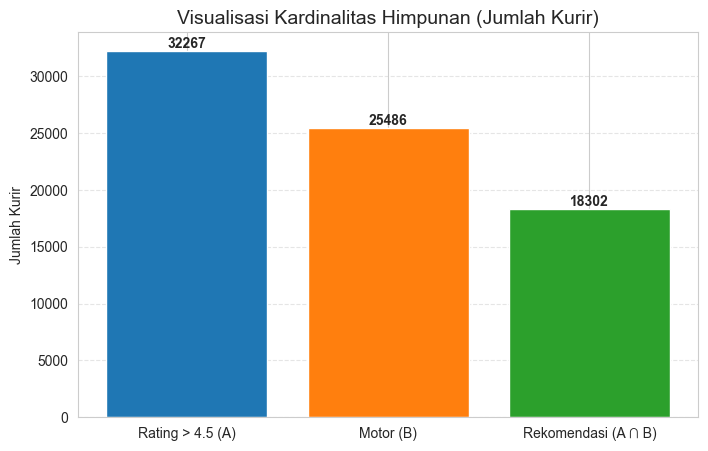

In [ ]:
# Bar chart
plt.figure(figsize=(8, 5))
labels = ['Rating > 4.5 (A)', 'Motor (B)', 'Rekomendasi (A ∩ B)']
values = [len(himpunan_rating_tinggi), len(himpunan_motor), len(rekomendasi_kurir)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

bars = plt.bar(labels, values, color=colors)
plt.title("Visualisasi Kardinalitas Himpunan (Jumlah Kurir)", fontsize=14)
plt.ylabel("Jumlah Kurir")
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontweight='bold')

print("Interpretasi Visual:")
print(f"Diagram ini menunjukkan penyusutan jumlah kandidat dari ribuan data menjadi {values[2]} kurir terbaik.")
plt.show()

### **Interpretasi Visual: Efisiensi Seleksi Himpunan**

Grafik batang (*Bar Chart*) di atas memvisualisasikan hasil operasi kardinalitas himpunan ($n$) dalam proses seleksi kurir. Berikut adalah analisisnya:

1.  **Distribusi Himpunan Awal:**
    * **Bar Biru ($A$):** Mewakili jumlah kurir dengan performa tinggi (*Rating > 4.5*).
    * **Bar Oranye ($B$):** Mewakili jumlah kurir yang menggunakan kendaraan lincah (*Motorcycle*).
    * Kedua himpunan ini memiliki populasi yang besar, namun tidak semua anggotanya memenuhi kriteria optimasi secara bersamaan.

2.  **Hasil Optimasi (Irisan):**
    * **Bar Hijau ($A \cap B$):** Mewakili kurir yang masuk dalam **Rekomendasi Sistem**.
    * Secara visual, terlihat adanya **penyusutan (reduksi)** jumlah kandidat dibandingkan dua bar sebelumnya.
    * Tinggi bar hijau ini adalah visualisasi dari $n(A \cap B)$, yaitu jumlah kurir yang tersaring setelah melewati dua "gerbang logika" sekaligus.

3.  **Kesimpulan:**
    Grafik ini membuktikan bahwa penerapan **Teori Himpunan** efektif merampingkan ruang pencarian (*search space*). Dari puluhan ribu data mentah, sistem berhasil mengisolasi sekelompok kecil kurir elit (Bar Hijau) yang diprediksi memberikan waktu pengiriman tercepat.

## **5. Visualisasi & Analisis Hasil**
Bagian ini menampilkan:
1. **Peta Rute:** Representasi visual dari Graf.
2. **Grafik Analisis:** Pembuktian dampak cuaca terhadap waktu pengiriman.

In [20]:
# Ambil 1 sampel data untuk digambar
sample = df_clean.iloc[100] # Ganti angka ini untuk coba data lain

# Koordinat
store_loc = [sample['Store_Latitude'], sample['Store_Longitude']]
drop_loc = [sample['Drop_Latitude'], sample['Drop_Longitude']]

# Buat Peta
m = folium.Map(location=store_loc, zoom_start=13)

# Marker Toko (Merah)
folium.Marker(store_loc, popup="TOKO", icon=folium.Icon(color='red', icon='store', prefix='fa')).add_to(m)

# Marker Tujuan (Hijau)
folium.Marker(drop_loc, popup="TUJUAN", icon=folium.Icon(color='green', icon='home', prefix='fa')).add_to(m)

# Garis Hubung (Edge)
folium.PolyLine([store_loc, drop_loc], color='blue', weight=4, tooltip=f"Jarak: {sample['jarak_km']:.2f} KM").add_to(m)

print(f"Rute untuk Order ID: {sample['Order_ID']}")
m

Rute untuk Order ID: oska955853002


C:\Users\Trishaa\AppData\Local\Temp\ipykernel_14052\1409552378.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_clean, x='Weather', y='estimasi_waktu', palette='viridis', errorbar=None)


✅ Grafik berhasil disimpan di folder output.


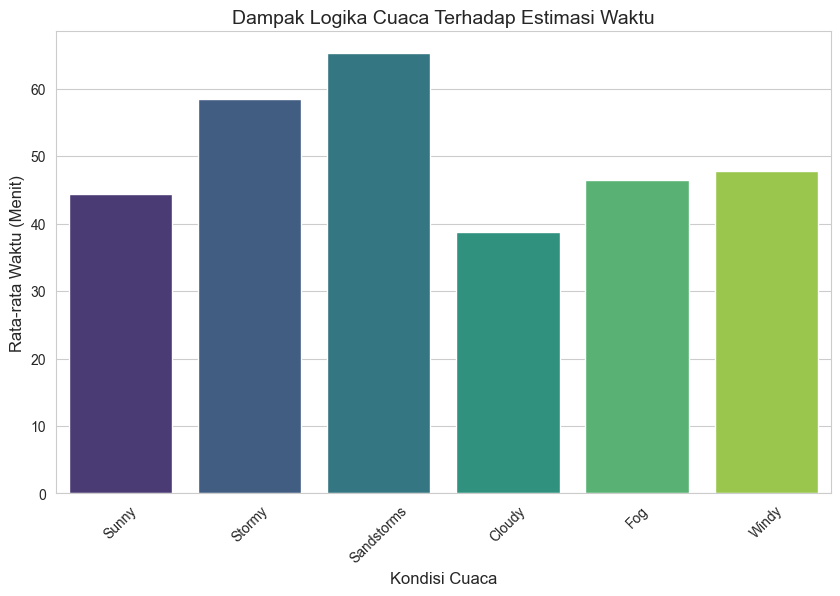

In [9]:
plt.figure(figsize=(10, 6))

# Membuat Bar Plot: Hubungan Cuaca vs Waktu
sns.barplot(data=df_clean, x='Weather', y='estimasi_waktu', palette='viridis', errorbar=None)

plt.title('Dampak Logika Cuaca Terhadap Estimasi Waktu', fontsize=14)
plt.xlabel('Kondisi Cuaca', fontsize=12)
plt.ylabel('Rata-rata Waktu (Menit)', fontsize=12)
plt.xticks(rotation=45)

# Simpan Grafik ke folder output (Pastikan folder output sudah dibuat)
try:
    plt.savefig('../output/grafik_analisis.png', bbox_inches='tight')
    print("✅ Grafik berhasil disimpan di folder output.")
except:
    print("⚠️ Folder output belum ada, grafik hanya ditampilkan.")

plt.show()

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import folium

# 1. Siapkan Daftar ID (Pastikan df_clean sudah ada kolom 'estimasi_waktu' dan 'jarak_km')
# Ambil sampel 20 data
try:
    sample_ids = df_clean.sample(20)['Order_ID'].tolist()
except:
    print("⚠️ Warning: df_clean belum siap/kosong. Pastikan cell sebelumnya sudah dijalankan.")
    sample_ids = []

# 2. Buat Widget
title_widget = widgets.HTML("<h3>🚀 Simulasi Navigasi Logistik Interaktif</h3>")

dropdown = widgets.Dropdown(
    options=sample_ids,
    description='Pilih Order ID:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

btn_run = widgets.Button(
    description='🔎 Cek Rute & Estimasi',
    button_style='info', # warna biru
    icon='search',
    layout=widgets.Layout(width='200px')
)

output_area = widgets.Output()

# 3. Fungsi Logika saat Tombol Diklik
def on_click_run(b):
    with output_area:
        clear_output() # Hapus hasil sebelumnya
        
        try:
            # Ambil ID yang dipilih
            selected_id = dropdown.value
            # Ambil data baris pertama yang cocok
            data = df_clean[df_clean['Order_ID'] == selected_id].iloc[0]
            
            # --- TAMPILKAN DATA LOGIKA (TEXT) ---
            print(f"📦 Order ID       : {data['Order_ID']}")
            print(f"📍 Jarak Fisik    : {data['jarak_km']:.2f} KM")
            # Sesuaikan nama kolom cuaca/traffic dengan datasetmu
            cuaca = data.get('Weather', data.get('Weather_conditions', '-'))
            traffic = data.get('Traffic', data.get('Road_traffic_density', '-'))
            
            print(f"⛅ Cuaca          : {cuaca}")
            print(f"🚗 Traffic        : {traffic}")
            print("-" * 40)
            print(f"⏱️ ESTIMASI WAKTU : {data['estimasi_waktu']:.0f} Menit")
            
            # Cek Penalti Logika
            is_delay = False
            if cuaca in ['Stormy', 'Sandstorms', 'Fog', 'Windy']: is_delay = True
            if traffic in ['Jam', 'High']: is_delay = True
            
            if is_delay:
                print("⚠️ STATUS: DELAY (Penalti Logika Diterapkan)")
            else:
                print("✅ STATUS: NORMAL")
                
            # --- TAMPILKAN PETA (VISUALISASI) ---
            store_loc = [data['Store_Latitude'], data['Store_Longitude']]
            drop_loc = [data['Drop_Latitude'], data['Drop_Longitude']]

            # Buat Peta dengan ukuran fix biar gak blank
            m = folium.Map(location=store_loc, zoom_start=13, tiles='OpenStreetMap')
            
            # Marker Toko (Merah) - Pakai icon standar biar aman
            folium.Marker(
                store_loc, popup="TOKO ASAL", 
                tooltip="Toko",
                icon=folium.Icon(color='red', icon='home')
            ).add_to(m)
            
            # Marker Tujuan (Hijau)
            folium.Marker(
                drop_loc, popup="TUJUAN", 
                tooltip="Tujuan",
                icon=folium.Icon(color='green', icon='flag')
            ).add_to(m)
            
            # Garis Rute
            folium.PolyLine(
                [store_loc, drop_loc], color='blue', weight=4, opacity=0.7,
                tooltip=f"Jarak: {data['jarak_km']:.2f} KM"
            ).add_to(m)
            
            # FITUR PENTING: Auto-Zoom supaya kedua titik kelihatan
            m.fit_bounds([store_loc, drop_loc])
            
            display(m)
            
        except Exception as e:
            print(f"❌ Terjadi Error: {e}")
            print("Cek apakah kolom 'jarak_km' atau 'estimasi_waktu' sudah dihitung di cell atas?")

# 4. Pasang Event Handler
btn_run.on_click(on_click_run)

# 5. Tampilkan GUI
display(title_widget, dropdown, btn_run, output_area)

HTML(value='<h3>🚀 Simulasi Navigasi Logistik Interaktif</h3>')

Dropdown(description='Pilih Order ID:', layout=Layout(width='400px'), options=('ahgo223488817', 'lihq948208577…

Button(button_style='info', description='🔎 Cek Rute & Estimasi', icon='search', layout=Layout(width='200px'), …

Output()